In [1]:
#Import my dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
import os
from pandas import read_csv
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from sklearn import metrics 
import warnings

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

np.random.seed(1234)

2022-01-09 23:46:59.911380: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [2]:
df = pd.read_csv('PROMO_GD_OPD_203810823_NEW.csv', parse_dates=['cal_dt'])

df.index = df['cal_dt']
df = df.reindex(pd.date_range(min(df['cal_dt']),
                                          max(df['cal_dt']),
                                          freq='D'))
df = df.drop('cal_dt', axis=1)

df = df
df = df.reset_index(level=0)
df = df.rename(columns={"index": "cal_dt"})
df.head()

,cal_dt,merch_dept,class_nbr,class_name,mfg_brand_name,oms_id,internet_sku_name,is_incart,is_special_buy,is_bau,is_major_event,is_event,ty_regular_retail,ty_effective_retail,markdown,ty_promo_gross_demand,promo_pen,ty_gross_demand
0,2018-01-01,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,114.67,14.33,0.0,0.0,1140.0
1,2018-01-02,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,2064.0
2,2018-01-03,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,1776.0
3,2018-01-04,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,127.83,1.17,0.0,0.0,1406.0
4,2018-01-05,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,124.81,4.19,0.0,0.0,1494.0


In [3]:
# Create data as an index
df = df.set_index("cal_dt")
df = df.set_index(pd.to_datetime(df.index))

In [4]:
df.head()

,merch_dept,class_nbr,class_name,mfg_brand_name,oms_id,internet_sku_name,is_incart,is_special_buy,is_bau,is_major_event,is_event,ty_regular_retail,ty_effective_retail,markdown,ty_promo_gross_demand,promo_pen,ty_gross_demand
cal_dt,,,,,,,,,,,,,,,,,
2018-01-01,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,114.67,14.33,0.0,0.0,1140.0
2018-01-02,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,2064.0
2018-01-03,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,1776.0
2018-01-04,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,127.83,1.17,0.0,0.0,1406.0
2018-01-05,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,124.81,4.19,0.0,0.0,1494.0


In [5]:
# Fill in missing values with median
df= df.fillna((df.median())) # see if there is a huge difference between mean and median
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,merch_dept,class_nbr,class_name,mfg_brand_name,oms_id,internet_sku_name,is_incart,is_special_buy,is_bau,is_major_event,is_event,ty_regular_retail,ty_effective_retail,markdown,ty_promo_gross_demand,promo_pen,ty_gross_demand
cal_dt,,,,,,,,,,,,,,,,,
2018-01-01,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,114.67,14.33,0.0,0.0,1140.0
2018-01-02,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,2064.0
2018-01-03,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,1776.0
2018-01-04,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,127.83,1.17,0.0,0.0,1406.0
2018-01-05,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,0.0,129.0,124.81,4.19,0.0,0.0,1494.0


In [6]:
df2 = df[['ty_gross_demand']]

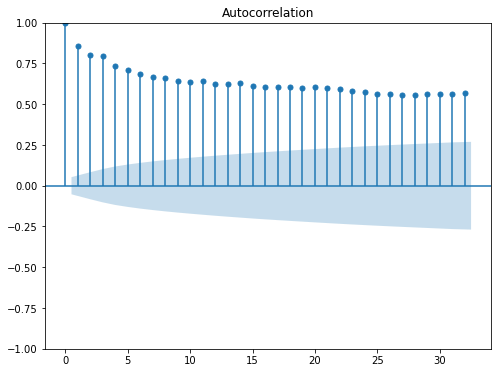

In [7]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df2)
pyplot.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


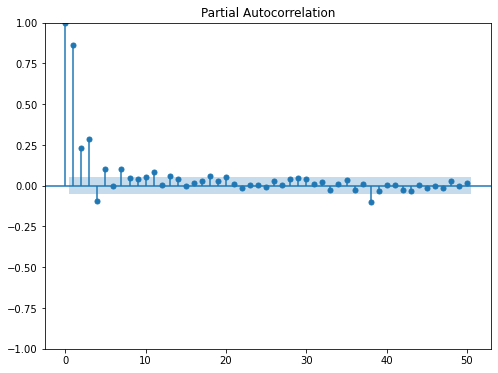

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df2, lags=50)
pyplot.show()

In [9]:
df['lagprice1'] = df['ty_gross_demand'].shift(1)
df['lagprice2'] = df['ty_gross_demand'].shift(2)
df['lagprice3'] = df['ty_gross_demand'].shift(3)
df['lagprice4'] = df['ty_gross_demand'].shift(4)
df['lagprice5'] = df['ty_gross_demand'].shift(5)
df['lagprice7'] = df['ty_gross_demand'].shift(7)
df['lagprice11'] = df['ty_gross_demand'].shift(11)

In [10]:
df = df.reset_index(level=0)
df = df.rename(columns={"index": "cal_dt"})

In [11]:
df = df.drop([0, 1,2,3,4,5,6,7,8,9,10,11])

In [12]:
df.head(5)

,cal_dt,merch_dept,class_nbr,class_name,mfg_brand_name,oms_id,internet_sku_name,is_incart,is_special_buy,is_bau,...,ty_promo_gross_demand,promo_pen,ty_gross_demand,lagprice1,lagprice2,lagprice3,lagprice4,lagprice5,lagprice7,lagprice11
12,2018-01-13,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,...,0.0,0.0,1793.0,1548.0,1935.0,1032.0,1793.0,1548.0,1032.0,2064.0
13,2018-01-14,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,...,0.0,0.0,1161.0,1793.0,1548.0,1935.0,1032.0,1793.0,1161.0,1776.0
14,2018-01-15,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,...,0.0,0.0,1419.0,1161.0,1793.0,1548.0,1935.0,1032.0,1548.0,1406.0
15,2018-01-16,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,...,0.0,0.0,1032.0,1419.0,1161.0,1793.0,1548.0,1935.0,1793.0,1494.0
16,2018-01-17,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,...,0.0,0.0,1905.0,1032.0,1419.0,1161.0,1793.0,1548.0,1032.0,1032.0


In [13]:
# Create data as an index
df = df.set_index("cal_dt")
df = df.set_index(pd.to_datetime(df.index))
df.head()

,merch_dept,class_nbr,class_name,mfg_brand_name,oms_id,internet_sku_name,is_incart,is_special_buy,is_bau,is_major_event,...,ty_promo_gross_demand,promo_pen,ty_gross_demand,lagprice1,lagprice2,lagprice3,lagprice4,lagprice5,lagprice7,lagprice11
cal_dt,,,,,,,,,,,,,,,,,,,,,
2018-01-13,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,0.0,0.0,1793.0,1548.0,1935.0,1032.0,1793.0,1548.0,1032.0,2064.0
2018-01-14,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,0.0,0.0,1161.0,1793.0,1548.0,1935.0,1032.0,1793.0,1161.0,1776.0
2018-01-15,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,0.0,0.0,1419.0,1161.0,1793.0,1548.0,1935.0,1032.0,1548.0,1406.0
2018-01-16,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,0.0,0.0,1032.0,1419.0,1161.0,1793.0,1548.0,1935.0,1793.0,1494.0
2018-01-17,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,0.0,0.0,1905.0,1032.0,1419.0,1161.0,1793.0,1548.0,1032.0,1032.0


In [14]:
# Fill in missing values with mean
df= df.fillna((df.median())) # see if there is a huge difference between mean and median
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,merch_dept,class_nbr,class_name,mfg_brand_name,oms_id,internet_sku_name,is_incart,is_special_buy,is_bau,is_major_event,...,ty_promo_gross_demand,promo_pen,ty_gross_demand,lagprice1,lagprice2,lagprice3,lagprice4,lagprice5,lagprice7,lagprice11
cal_dt,,,,,,,,,,,,,,,,,,,,,
2018-01-13,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,0.0,0.0,1793.0,1548.0,1935.0,1032.0,1793.0,1548.0,1032.0,2064.0
2018-01-14,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,0.0,0.0,1161.0,1793.0,1548.0,1935.0,1032.0,1793.0,1161.0,1776.0
2018-01-15,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,0.0,0.0,1419.0,1161.0,1793.0,1548.0,1935.0,1032.0,1548.0,1406.0
2018-01-16,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,0.0,0.0,1032.0,1419.0,1161.0,1793.0,1548.0,1935.0,1793.0,1494.0
2018-01-17,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,0.0,0.0,1905.0,1032.0,1419.0,1161.0,1793.0,1548.0,1032.0,1032.0


In [15]:
# Add Month and Day of Week
df['month'] = [df.index[i].month for i in range(len(df))]
df['dayofweek'] = [df.index[i].day for i in range(len(df))]
df.head(15)

,merch_dept,class_nbr,class_name,mfg_brand_name,oms_id,internet_sku_name,is_incart,is_special_buy,is_bau,is_major_event,...,ty_gross_demand,lagprice1,lagprice2,lagprice3,lagprice4,lagprice5,lagprice7,lagprice11,month,dayofweek
cal_dt,,,,,,,,,,,,,,,,,,,,,
2018-01-13,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1793.0,1548.0,1935.0,1032.0,1793.0,1548.0,1032.0,2064.0,1,13
2018-01-14,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1161.0,1793.0,1548.0,1935.0,1032.0,1793.0,1161.0,1776.0,1,14
2018-01-15,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1419.0,1161.0,1793.0,1548.0,1935.0,1032.0,1548.0,1406.0,1,15
2018-01-16,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1032.0,1419.0,1161.0,1793.0,1548.0,1935.0,1793.0,1494.0,1,16
2018-01-17,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1905.0,1032.0,1419.0,1161.0,1793.0,1548.0,1032.0,1032.0,1,17
2018-01-18,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,2039.0,1905.0,1032.0,1419.0,1161.0,1793.0,1935.0,1161.0,1,18
2018-01-19,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,2180.0,2039.0,1905.0,1032.0,1419.0,1161.0,1548.0,1548.0,1,19
2018-01-20,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1935.0,2180.0,2039.0,1905.0,1032.0,1419.0,1793.0,1793.0,1,20
2018-01-21,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1935.0,1935.0,2180.0,2039.0,1905.0,1032.0,1161.0,1032.0,1,21


In [16]:
df.isna().sum().sum()

0

In [17]:
# Add Weekend Indicator
df['Weekday'] = [df.index[i].dayofweek for i in range(len(df))]  # monday = 0, sunday = 6
df['weekend_indi'] = 0
df.loc[df['Weekday'].isin([4, 5, 6]), 'weekend_indi'] = 1 

In [18]:
# Add is Leap Year
df['isLeapYear'] = [df.index[i].is_leap_year for i in range(len(df))]
df[['isLeapYear']] = df[['isLeapYear']].astype(int)
df.head()

,merch_dept,class_nbr,class_name,mfg_brand_name,oms_id,internet_sku_name,is_incart,is_special_buy,is_bau,is_major_event,...,lagprice3,lagprice4,lagprice5,lagprice7,lagprice11,month,dayofweek,Weekday,weekend_indi,isLeapYear
cal_dt,,,,,,,,,,,,,,,,,,,,,
2018-01-13,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1032.0,1793.0,1548.0,1032.0,2064.0,1,13,5,1,0
2018-01-14,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1935.0,1032.0,1793.0,1161.0,1776.0,1,14,6,1,0
2018-01-15,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1548.0,1935.0,1032.0,1548.0,1406.0,1,15,0,0,0
2018-01-16,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1793.0,1548.0,1935.0,1793.0,1494.0,1,16,1,0,0
2018-01-17,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1161.0,1793.0,1548.0,1032.0,1032.0,1,17,2,0,0


In [19]:
# Add Quarter
df['quarter'] = [df.index[i].quarter for i in range(len(df))]
df.head()

,merch_dept,class_nbr,class_name,mfg_brand_name,oms_id,internet_sku_name,is_incart,is_special_buy,is_bau,is_major_event,...,lagprice4,lagprice5,lagprice7,lagprice11,month,dayofweek,Weekday,weekend_indi,isLeapYear,quarter
cal_dt,,,,,,,,,,,,,,,,,,,,,
2018-01-13,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1793.0,1548.0,1032.0,2064.0,1,13,5,1,0,1
2018-01-14,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1032.0,1793.0,1161.0,1776.0,1,14,6,1,0,1
2018-01-15,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1935.0,1032.0,1548.0,1406.0,1,15,0,0,0,1
2018-01-16,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1548.0,1935.0,1793.0,1494.0,1,16,1,0,0,1
2018-01-17,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1793.0,1548.0,1032.0,1032.0,1,17,2,0,0,1


In [20]:
# Add US Holidays
import pandas as pd
from pandas.tseries.holiday import *
from pandas.tseries.offsets import CustomBusinessDay
import numpy as np
import pandas as pd
import holidays
import datetime

class GothamBusinessCalendar(AbstractHolidayCalendar):
   rules = [
     Holiday('New Year', month=1, day=1, observance=sunday_to_monday),
     Holiday('Groundhog Day', month=1, day=6, observance=sunday_to_monday),
     Holiday('St. Patricks Day', month=3, day=17, observance=sunday_to_monday),
     Holiday('April Fools Day', month=4, day=1),
     Holiday('Good Friday', month=1, day=1, offset=[Easter(), Day(-2)]),
     Holiday('Labor Day', month=5, day=1, observance=sunday_to_monday),
     Holiday('Canada Day', month=7, day=1, observance=sunday_to_monday),
     Holiday('July 4th', month=7, day=4, observance=nearest_workday),
     Holiday('All Saints Day', month=11, day=1, observance=sunday_to_monday),
     Holiday('Christmas', month=12, day=25, observance=nearest_workday),
   ]

In [21]:
for date in holidays.UnitedStates(years = [2018,2019,2020,2021]).items():
  print(date)

(datetime.date(2018, 1, 1), "New Year's Day")
(datetime.date(2018, 1, 15), 'Martin Luther King Jr. Day')
(datetime.date(2018, 2, 19), "Washington's Birthday")
(datetime.date(2018, 5, 28), 'Memorial Day')
(datetime.date(2018, 7, 4), 'Independence Day')
(datetime.date(2018, 9, 3), 'Labor Day')
(datetime.date(2018, 10, 8), 'Columbus Day')
(datetime.date(2018, 11, 11), 'Veterans Day')
(datetime.date(2018, 11, 12), 'Veterans Day (Observed)')
(datetime.date(2018, 11, 22), 'Thanksgiving')
(datetime.date(2018, 12, 25), 'Christmas Day')
(datetime.date(2019, 1, 1), "New Year's Day")
(datetime.date(2019, 1, 21), 'Martin Luther King Jr. Day')
(datetime.date(2019, 2, 18), "Washington's Birthday")
(datetime.date(2019, 5, 27), 'Memorial Day')
(datetime.date(2019, 7, 4), 'Independence Day')
(datetime.date(2019, 9, 2), 'Labor Day')
(datetime.date(2019, 10, 14), 'Columbus Day')
(datetime.date(2019, 11, 11), 'Veterans Day')
(datetime.date(2019, 11, 28), 'Thanksgiving')
(datetime.date(2019, 12, 25), 'Chri

In [22]:
us_holiday = []
for date in holidays.UnitedStates(years = [2018,2019,2020,2021]).items():
  us_holiday.append(str(date[0]))

In [23]:
df.head()

,merch_dept,class_nbr,class_name,mfg_brand_name,oms_id,internet_sku_name,is_incart,is_special_buy,is_bau,is_major_event,...,lagprice4,lagprice5,lagprice7,lagprice11,month,dayofweek,Weekday,weekend_indi,isLeapYear,quarter
cal_dt,,,,,,,,,,,,,,,,,,,,,
2018-01-13,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1793.0,1548.0,1032.0,2064.0,1,13,5,1,0,1
2018-01-14,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1032.0,1793.0,1161.0,1776.0,1,14,6,1,0,1
2018-01-15,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1935.0,1032.0,1548.0,1406.0,1,15,0,0,0,1
2018-01-16,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1548.0,1935.0,1793.0,1494.0,1,16,1,0,0,1
2018-01-17,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,0.0,0.0,...,1793.0,1548.0,1032.0,1032.0,1,17,2,0,0,1


In [24]:
df.tail()

,merch_dept,class_nbr,class_name,mfg_brand_name,oms_id,internet_sku_name,is_incart,is_special_buy,is_bau,is_major_event,...,lagprice4,lagprice5,lagprice7,lagprice11,month,dayofweek,Weekday,weekend_indi,isLeapYear,quarter
cal_dt,,,,,,,,,,,,,,,,,,,,,
2021-10-14,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,1.0,0.0,...,5838.0,5453.0,6193.0,4645.0,10,14,3,0,0,4
2021-10-15,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,1.0,0.0,...,6933.0,5838.0,6738.0,7155.0,10,15,4,1,0,4
2021-10-16,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,1.0,0.0,...,6034.0,6933.0,5453.0,6530.0,10,16,5,1,0,4
2021-10-17,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,1.0,0.0,...,6797.0,6034.0,5838.0,6637.0,10,17,6,1,0,4
2021-10-18,25H-HARDWARE (25H),025-012,PNEUMATIC FASTENERS,RYOBI,203810823,203810823-ONE 18V Cordless AirStrike 18 Gauge...,0.0,0.0,1.0,0.0,...,9140.0,6797.0,6933.0,6193.0,10,18,0,0,0,4


In [25]:
import datetime
start_date = datetime.datetime(year = 2018, month = 1, day=13)
end_date = datetime.datetime(year = 2021, month = 10, day = 18)
pd.date_range(start_date, end_date)

DatetimeIndex(['2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22',
               ...
               '2021-10-09', '2021-10-10', '2021-10-11', '2021-10-12',
               '2021-10-13', '2021-10-14', '2021-10-15', '2021-10-16',
               '2021-10-17', '2021-10-18'],
              dtype='datetime64[ns]', length=1375, freq='D')

In [26]:
df_date = pd.DataFrame()# Convert categorical data to One Hot Encoding
df = pd.get_dummies(df, columns=["month", "dayofweek","Weekday","quarter","merch_dept","class_nbr","class_name","mfg_brand_name","internet_sku_name","oms_id"], prefix=["month", "dayofweek","Weekday","quarter","merch_dept","class_nbr","class_name","mfg_brand_name","internet_sku_name","oms_id"])
df_date['Dates'] = pd.date_range(start_date, end_date)

In [27]:
df['Is_Holiday'] = [
                    1 if str(val).split()[0] in us_holiday else 0 for val in df_date['Dates']
]

In [28]:
df.head()

,is_incart,is_special_buy,is_bau,is_major_event,is_event,ty_regular_retail,ty_effective_retail,markdown,ty_promo_gross_demand,promo_pen,...,quarter_2,quarter_3,quarter_4,merch_dept_25H-HARDWARE (25H),class_nbr_025-012,class_name_PNEUMATIC FASTENERS,mfg_brand_name_RYOBI,internet_sku_name_203810823-ONE 18V Cordless AirStrike 18 Gauge Brad Nailer Tool Only with Sample Nails,oms_id_203810823,Is_Holiday
cal_dt,,,,,,,,,,,,,,,,,,,,,
2018-01-13,0.0,0.0,0.0,0.0,0.0,129.0,128.14,0.86,0.0,0.0,...,0,0,0,1,1,1,1,1,1,0
2018-01-14,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,...,0,0,0,1,1,1,1,1,1,0
2018-01-15,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,...,0,0,0,1,1,1,1,1,1,1
2018-01-16,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,...,0,0,0,1,1,1,1,1,1,0
2018-01-17,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,...,0,0,0,1,1,1,1,1,1,0


In [29]:
# Thanksgiving
df.loc['2018-11-22', 'Is_Holiday'] = 1
df.loc['2019-11-28', 'Is_Holiday'] = 1
df.loc['2020-11-26', 'Is_Holiday'] = 1

# Black Friday
df.loc['2018-11-23', 'Is_Holiday'] = 1
df.loc['2019-11-29', 'Is_Holiday'] = 1
df.loc['2020-11-27', 'Is_Holiday'] = 1

# Cyber Monday
df.loc['2018-11-26', 'Is_Holiday'] = 1
df.loc['2019-12-2', 'Is_Holiday'] = 1
df.loc['2020-11-30', 'Is_Holiday'] = 1

# Valentines Day
df.loc['2018-02-14', 'Is_Holiday'] = 1
df.loc['2019-02-14', 'Is_Holiday'] = 1
df.loc['2020-02-14', 'Is_Holiday'] = 1
df.loc['2021-02-14', 'Is_Holiday'] = 1

# Martin Luther King
df.loc['2018-01-15', 'Is_Holiday'] = 1
df.loc['2019-01-21', 'Is_Holiday'] = 1
df.loc['2020-01-20', 'Is_Holiday'] = 1
df.loc['2021-01-18', 'Is_Holiday'] = 1

# Washington's Birthday
df.loc['2018-02-19', 'Is_Holiday'] = 1
df.loc['2019-02-18', 'Is_Holiday'] = 1
df.loc['2020-02-17', 'Is_Holiday'] = 1
df.loc['2021-02-15', 'Is_Holiday'] = 1

# Memorial Day
df.loc['2018-05-28', 'Is_Holiday'] = 1
df.loc['2019-05-27', 'Is_Holiday'] = 1
df.loc['2020-05-25', 'Is_Holiday'] = 1
df.loc['2021-05-31', 'Is_Holiday'] = 1

# Veterans Days
df.loc['2018-11-11', 'Is_Holiday'] = 1
df.loc['2019-11-11', 'Is_Holiday'] = 1
df.loc['2020-11-11', 'Is_Holiday'] = 1

# Easter
df.loc['2018-04-01', 'Is_Holiday'] = 1
df.loc['2019-04-21', 'Is_Holiday'] = 1
df.loc['2020-04-12', 'Is_Holiday'] = 1
df.loc['2021-04-04', 'Is_Holiday'] = 1

In [30]:
df.head()

,is_incart,is_special_buy,is_bau,is_major_event,is_event,ty_regular_retail,ty_effective_retail,markdown,ty_promo_gross_demand,promo_pen,...,quarter_2,quarter_3,quarter_4,merch_dept_25H-HARDWARE (25H),class_nbr_025-012,class_name_PNEUMATIC FASTENERS,mfg_brand_name_RYOBI,internet_sku_name_203810823-ONE 18V Cordless AirStrike 18 Gauge Brad Nailer Tool Only with Sample Nails,oms_id_203810823,Is_Holiday
cal_dt,,,,,,,,,,,,,,,,,,,,,
2018-01-13,0.0,0.0,0.0,0.0,0.0,129.0,128.14,0.86,0.0,0.0,...,0,0,0,1,1,1,1,1,1,0
2018-01-14,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,...,0,0,0,1,1,1,1,1,1,0
2018-01-15,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,...,0,0,0,1,1,1,1,1,1,1
2018-01-16,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,...,0,0,0,1,1,1,1,1,1,0
2018-01-17,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,...,0,0,0,1,1,1,1,1,1,0


In [31]:
def filter_df_corr(inp_data, corr_val):
    '''
    Returns an array or dataframe (based on type(inp_data) adjusted to drop \
        columns with high correlation to one another. Takes second arg corr_val
        that defines the cutoff

    ----------
    inp_data : np.array, pd.DataFrame
        Values to consider
    corr_val : float
        Value [0, 1] on which to base the correlation cutoff
    '''
    # Creates Correlation Matrix
    if isinstance(inp_data, np.ndarray):
        inp_data = pd.DataFrame(data=inp_data)
        array_flag = True
    else:
        array_flag = False
    corr_matrix = inp_data.corr()

    # Iterates through Correlation Matrix Table to find correlated columns
    drop_cols = []
    n_cols = len(corr_matrix.columns)

    for i in range(n_cols):
        for k in range(i+1, n_cols):
            val = corr_matrix.iloc[k, i]
            col = corr_matrix.columns[i]
            row = corr_matrix.index[k]
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col, "|", row, "|", round(val, 2))
                drop_cols.append(col)

    # Drops the correlated columns
    drop_cols = set(drop_cols)
    inp_data = inp_data.drop(columns=drop_cols)
    # Return same type as inp
    if array_flag:
        return inp_data.values
    else:
        return inp_data

In [32]:
new_df = filter_df_corr(df, 0.90)

ty_effective_retail | markdown | -0.96


In [33]:
new_df

,is_incart,is_special_buy,is_bau,is_major_event,is_event,ty_regular_retail,markdown,ty_promo_gross_demand,promo_pen,ty_gross_demand,...,quarter_2,quarter_3,quarter_4,merch_dept_25H-HARDWARE (25H),class_nbr_025-012,class_name_PNEUMATIC FASTENERS,mfg_brand_name_RYOBI,internet_sku_name_203810823-ONE 18V Cordless AirStrike 18 Gauge Brad Nailer Tool Only with Sample Nails,oms_id_203810823,Is_Holiday
cal_dt,,,,,,,,,,,,,,,,,,,,,
2018-01-13,0.0,0.0,0.0,0.0,0.0,129.0,0.86,0.00,0.00,1793.0,...,0,0,0,1,1,1,1,1,1,0
2018-01-14,0.0,0.0,0.0,0.0,0.0,129.0,0.00,0.00,0.00,1161.0,...,0,0,0,1,1,1,1,1,1,0
2018-01-15,0.0,0.0,0.0,0.0,0.0,129.0,0.00,0.00,0.00,1419.0,...,0,0,0,1,1,1,1,1,1,1
2018-01-16,0.0,0.0,0.0,0.0,0.0,129.0,0.00,0.00,0.00,1032.0,...,0,0,0,1,1,1,1,1,1,0
2018-01-17,0.0,0.0,0.0,0.0,0.0,129.0,0.00,0.00,0.00,1905.0,...,0,0,0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-14,0.0,0.0,1.0,0.0,1.0,129.0,18.58,1695.16,0.19,9140.0,...,0,0,1,1,1,1,1,1,1,0
2021-10-15,0.0,0.0,1.0,0.0,1.0,129.0,18.75,537.76,0.06,8647.0,...,0,0,1,1,1,1,1,1,1,0
2021-10-16,0.0,0.0,1.0,0.0,1.0,129.0,14.92,377.72,0.05,7041.0,...,0,0,1,1,1,1,1,1,1,0


In [34]:
df1 = df.copy()

In [35]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_incart,1375.0,0.111273,0.314584,0.0,0.0,0.0,0.0,1.0
is_special_buy,1375.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
is_bau,1375.0,0.533091,0.499085,0.0,0.0,1.0,1.0,1.0
is_major_event,1375.0,0.009455,0.096809,0.0,0.0,0.0,0.0,1.0
is_event,1375.0,0.525091,0.499552,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
class_name_PNEUMATIC FASTENERS,1375.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
mfg_brand_name_RYOBI,1375.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
internet_sku_name_203810823-ONE 18V Cordless AirStrike 18 Gauge Brad Nailer Tool Only with Sample Nails,1375.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
oms_id_203810823,1375.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [36]:
data = df1.copy()
model1 = df1.copy()
model2 = df1.copy()
model3 = df1.copy()
model4 = df1.copy()
model5 = df1.copy()
model6 = df1.copy()
model7 = df1.copy()
model8 = df1.copy()
model9 = df1.copy()
model10 = df1.copy()

In [37]:
pd.options.display.max_seq_items = None
print(df1.columns)

Index(['is_incart', 'is_special_buy', 'is_bau', 'is_major_event', 'is_event',
       'ty_regular_retail', 'ty_effective_retail', 'markdown',
       'ty_promo_gross_demand', 'promo_pen', 'ty_gross_demand', 'lagprice1',
       'lagprice2', 'lagprice3', 'lagprice4', 'lagprice5', 'lagprice7',
       'lagprice11', 'weekend_indi', 'isLeapYear', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'dayofweek_7', 'dayofweek_8', 'dayofweek_9',
       'dayofweek_10', 'dayofweek_11', 'dayofweek_12', 'dayofweek_13',
       'dayofweek_14', 'dayofweek_15', 'dayofweek_16', 'dayofweek_17',
       'dayofweek_18', 'dayofweek_19', 'dayofweek_20', 'dayofweek_21',
       'dayofweek_22', 'dayofweek_23', 'dayofweek_24', 'dayofweek_25',
       'dayofweek_26', 'dayofweek_27', 'dayofweek_28', 'dayofweek_29',
      

In [38]:
# Identify Top Features
from numpy import loadtxt 
from xgboost import XGBRegressor
from matplotlib import pyplot

model = XGBRegressor()
model.fit(df1[['is_incart', 'is_special_buy', 'is_bau', 'is_major_event', 'is_event',
       'ty_regular_retail', 'ty_effective_retail', 'markdown',
       'ty_promo_gross_demand', 'promo_pen', 'lagprice1',
       'lagprice2', 'lagprice3', 'lagprice4', 'lagprice5', 'lagprice7',
       'lagprice11', 'weekend_indi', 'isLeapYear', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'dayofweek_7', 'dayofweek_8', 'dayofweek_9',
       'dayofweek_10', 'dayofweek_11', 'dayofweek_12', 'dayofweek_13',
       'dayofweek_14', 'dayofweek_15', 'dayofweek_16', 'dayofweek_17',
       'dayofweek_18', 'dayofweek_19', 'dayofweek_20', 'dayofweek_21',
       'dayofweek_22', 'dayofweek_23', 'dayofweek_24', 'dayofweek_25',
       'dayofweek_26', 'dayofweek_27', 'dayofweek_28', 'dayofweek_29',
       'dayofweek_30', 'dayofweek_31', 'Weekday_0', 'Weekday_1', 'Weekday_2',
       'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'quarter_1',
       'quarter_2', 'quarter_3', 'quarter_4', 'merch_dept_25H-HARDWARE (25H)',
       'class_nbr_025-012', 'class_name_PNEUMATIC FASTENERS',
       'mfg_brand_name_RYOBI',
       'internet_sku_name_203810823-ONE  18V Cordless AirStrike 18 Gauge Brad Nailer  Tool Only  with Sample Nails',
       'oms_id_203810823', 'Is_Holiday']], df1[['ty_gross_demand']])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:>

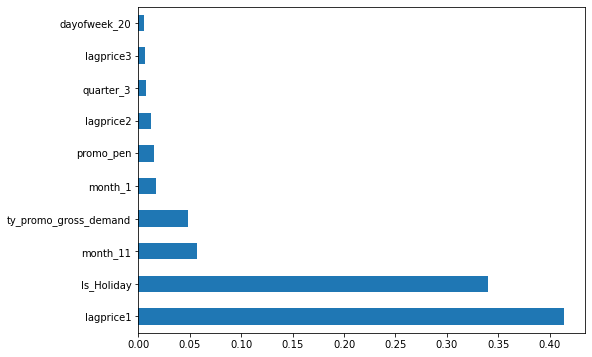

In [39]:
(pd.Series(model.feature_importances_, index = df1[['is_incart', 'is_special_buy', 'is_bau', 'is_major_event', 'is_event',
       'ty_regular_retail', 'ty_effective_retail', 'markdown',
       'ty_promo_gross_demand', 'promo_pen', 'lagprice1',
       'lagprice2', 'lagprice3', 'lagprice4', 'lagprice5', 'lagprice7',
       'lagprice11', 'weekend_indi', 'isLeapYear', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'dayofweek_7', 'dayofweek_8', 'dayofweek_9',
       'dayofweek_10', 'dayofweek_11', 'dayofweek_12', 'dayofweek_13',
       'dayofweek_14', 'dayofweek_15', 'dayofweek_16', 'dayofweek_17',
       'dayofweek_18', 'dayofweek_19', 'dayofweek_20', 'dayofweek_21',
       'dayofweek_22', 'dayofweek_23', 'dayofweek_24', 'dayofweek_25',
       'dayofweek_26', 'dayofweek_27', 'dayofweek_28', 'dayofweek_29',
       'dayofweek_30', 'dayofweek_31', 'Weekday_0', 'Weekday_1', 'Weekday_2',
       'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'quarter_1',
       'quarter_2', 'quarter_3', 'quarter_4', 'merch_dept_25H-HARDWARE (25H)',
       'class_nbr_025-012', 'class_name_PNEUMATIC FASTENERS',
       'mfg_brand_name_RYOBI',
       'internet_sku_name_203810823-ONE  18V Cordless AirStrike 18 Gauge Brad Nailer  Tool Only  with Sample Nails',
       'oms_id_203810823', 'Is_Holiday']].columns).nlargest(10).plot(kind = 'barh'))

In [40]:
#df1 = df1[['lagprice1', 'Is_Holiday','month_11','ty_promo_gross_demand','promo_pen','lagprice2','quarter_3','month_1','quarter_4','Weekday_5', 'ty_gross_demand']]

In [41]:
df1.head()

,is_incart,is_special_buy,is_bau,is_major_event,is_event,ty_regular_retail,ty_effective_retail,markdown,ty_promo_gross_demand,promo_pen,...,quarter_2,quarter_3,quarter_4,merch_dept_25H-HARDWARE (25H),class_nbr_025-012,class_name_PNEUMATIC FASTENERS,mfg_brand_name_RYOBI,internet_sku_name_203810823-ONE 18V Cordless AirStrike 18 Gauge Brad Nailer Tool Only with Sample Nails,oms_id_203810823,Is_Holiday
cal_dt,,,,,,,,,,,,,,,,,,,,,
2018-01-13,0.0,0.0,0.0,0.0,0.0,129.0,128.14,0.86,0.0,0.0,...,0,0,0,1,1,1,1,1,1,0
2018-01-14,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,...,0,0,0,1,1,1,1,1,1,0
2018-01-15,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,...,0,0,0,1,1,1,1,1,1,1
2018-01-16,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,...,0,0,0,1,1,1,1,1,1,0
2018-01-17,0.0,0.0,0.0,0.0,0.0,129.0,129.00,0.00,0.0,0.0,...,0,0,0,1,1,1,1,1,1,0


In [42]:
pd.options.display.max_seq_items = None
print(df1.columns)

Index(['is_incart', 'is_special_buy', 'is_bau', 'is_major_event', 'is_event',
       'ty_regular_retail', 'ty_effective_retail', 'markdown',
       'ty_promo_gross_demand', 'promo_pen', 'ty_gross_demand', 'lagprice1',
       'lagprice2', 'lagprice3', 'lagprice4', 'lagprice5', 'lagprice7',
       'lagprice11', 'weekend_indi', 'isLeapYear', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'dayofweek_7', 'dayofweek_8', 'dayofweek_9',
       'dayofweek_10', 'dayofweek_11', 'dayofweek_12', 'dayofweek_13',
       'dayofweek_14', 'dayofweek_15', 'dayofweek_16', 'dayofweek_17',
       'dayofweek_18', 'dayofweek_19', 'dayofweek_20', 'dayofweek_21',
       'dayofweek_22', 'dayofweek_23', 'dayofweek_24', 'dayofweek_25',
       'dayofweek_26', 'dayofweek_27', 'dayofweek_28', 'dayofweek_29',
      

In [43]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon
  for i in range(start, end):
    indices = range(i-window,i)
    X.append(dataset[indices])
    indicey = range(i+1, i+1+horizon)
    y.append(target[indicey])
  return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100
  print('Evaluation metric results:-')
  print(f'MSE is: {metrics.mean_squared_error(y_true, y_pred)}')
  print(f'MAE is: {metrics.mean_absolute_error(y_true, y_pred)}')
  print(f'RMSE is: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
  print(f'MAPE is: {mean_absolute_percentage_error(y_true, y_pred)}')
  print(f'R2 is : {metrics.r2_score(y_true, y_pred)}', end = '\n\n')

In [44]:
validate = model1[['is_incart', 'is_special_buy', 'is_bau', 'is_major_event', 'is_event',
       'ty_regular_retail', 'ty_effective_retail', 'markdown',
       'ty_promo_gross_demand', 'promo_pen','lagprice1',
       'lagprice2', 'lagprice3', 'lagprice4', 'lagprice5', 'lagprice7',
       'lagprice11', 'weekend_indi', 'isLeapYear', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'dayofweek_7', 'dayofweek_8', 'dayofweek_9',
       'dayofweek_10', 'dayofweek_11', 'dayofweek_12', 'dayofweek_13',
       'dayofweek_14', 'dayofweek_15', 'dayofweek_16', 'dayofweek_17',
       'dayofweek_18', 'dayofweek_19', 'dayofweek_20', 'dayofweek_21',
       'dayofweek_22', 'dayofweek_23', 'dayofweek_24', 'dayofweek_25',
       'dayofweek_26', 'dayofweek_27', 'dayofweek_28', 'dayofweek_29',
       'dayofweek_30', 'dayofweek_31', 'Weekday_0', 'Weekday_1', 'Weekday_2',
       'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'quarter_1',
       'quarter_2', 'quarter_3', 'quarter_4', 'merch_dept_25H-HARDWARE (25H)',
       'class_nbr_025-012', 'class_name_PNEUMATIC FASTENERS',
       'mfg_brand_name_RYOBI',
       'internet_sku_name_203810823-ONE  18V Cordless AirStrike 18 Gauge Brad Nailer  Tool Only  with Sample Nails',
       'oms_id_203810823', 'Is_Holiday', 'ty_gross_demand']].tail(15)

model1.drop(model1.tail(15).index, inplace = True)

In [45]:
from sklearn import preprocessing

x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(model1[['is_incart', 'is_special_buy', 'is_bau', 'is_major_event', 'is_event',
       'ty_regular_retail', 'ty_effective_retail', 'markdown',
       'ty_promo_gross_demand', 'promo_pen','lagprice1',
       'lagprice2', 'lagprice3', 'lagprice4', 'lagprice5', 'lagprice7',
       'lagprice11', 'weekend_indi', 'isLeapYear', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'dayofweek_7', 'dayofweek_8', 'dayofweek_9',
       'dayofweek_10', 'dayofweek_11', 'dayofweek_12', 'dayofweek_13',
       'dayofweek_14', 'dayofweek_15', 'dayofweek_16', 'dayofweek_17',
       'dayofweek_18', 'dayofweek_19', 'dayofweek_20', 'dayofweek_21',
       'dayofweek_22', 'dayofweek_23', 'dayofweek_24', 'dayofweek_25',
       'dayofweek_26', 'dayofweek_27', 'dayofweek_28', 'dayofweek_29',
       'dayofweek_30', 'dayofweek_31', 'Weekday_0', 'Weekday_1', 'Weekday_2',
       'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'quarter_1',
       'quarter_2', 'quarter_3', 'quarter_4', 'merch_dept_25H-HARDWARE (25H)',
       'class_nbr_025-012', 'class_name_PNEUMATIC FASTENERS',
       'mfg_brand_name_RYOBI',
       'internet_sku_name_203810823-ONE  18V Cordless AirStrike 18 Gauge Brad Nailer  Tool Only  with Sample Nails',
       'oms_id_203810823', 'Is_Holiday', 'ty_gross_demand']])

dataY = y_scaler.fit_transform(model1[['ty_gross_demand']])

In [46]:
hist_window = 5
horizon = 15
TRAIN_SPLIT = 1250
x_train_multi, y_train_multi = custom_ts_multi_data_prep(dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

BATCH_SIZE = 32
BUFFER_SIZE = 32
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

2022-01-09 23:47:03.260744: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-01-09 23:47:03.260967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 23:47:03.261613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-01-09 23:47:03.261661: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-01-09 23:47:03.264052: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-01-09 23:47:03.265241: I tensorflow/stream_executor/platform/default/d

In [47]:
x_train_multi.shape[0]

1245

In [48]:
x_train_multi.shape[1]

5

In [49]:
x_train_multi.shape[2]

81

In [50]:
x_train_multi.shape

(1245, 5, 81)

In [51]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [52]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [53]:
from keras.layers import LeakyReLU

In [54]:
from kerastuner import HyperModel

In [55]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPool1D,
    TimeDistributed,
    BatchNormalization,
    LSTM,
    GRU,
    SimpleRNN
)

INPUT_SHAPE = (x_train_multi.shape[1], x_train_multi.shape[2])
NUM_CLASSES = 1
input_shape = (x_train_multi.shape[1], x_train_multi.shape[2])
num_classes = 1

In [56]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers


leaky_relu_alpha = 0.1
filter_num = 25
activation_conv = 'tanh'
LSTM_act = 'tanh'
dense_act = 'softmax'
conv_dropout = .15
convLSTM = tf.keras.models.Sequential([ 
                                        # Conv1, 500 filters
                                        tf.keras.layers.Conv1D(activation = 'elu', filters=500, strides=1, padding = "causal", kernel_size = 3, input_shape = (x_train_multi.shape[1], x_train_multi.shape[2])),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha),
                                        tf.keras.layers.PReLU(),
                                        tf.keras.layers.Dropout(conv_dropout),
    
                                        # Conv2, 250 filters
                                        tf.keras.layers.Conv1D(activation = 'elu',filters=250, strides=1, kernel_size = 3, padding = "causal"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha),
                                        tf.keras.layers.PReLU(),
                                        tf.keras.layers.Dropout(conv_dropout),
    
                                        # Pool 1
                                        tf.keras.layers.MaxPooling1D(pool_size=1, strides=1, padding='same'),
    
                                        # Conv3, 125 filters
                                        tf.keras.layers.Conv1D(activation = 'elu',filters=125, strides=1, kernel_size = 3,padding = "causal"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha),
                                        tf.keras.layers.PReLU(),
                                        tf.keras.layers.Dropout(conv_dropout),
                                        
                                        # Pool 2
                                        tf.keras.layers.MaxPooling1D(pool_size=1, strides=1, padding='same'),
    
                                        # Conv4, 100 filters
                                        tf.keras.layers.Conv1D(activation = 'elu',filters=100, strides=1, kernel_size = 3, padding = "causal"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha),
                                        tf.keras.layers.PReLU(),
                                        tf.keras.layers.Dropout(conv_dropout),
    
                                        # Pool 3
                                        tf.keras.layers.MaxPooling1D(pool_size=1, strides=1, padding='same'),
    
                                        # Conv5, 50 filters
                                        tf.keras.layers.Conv1D(activation = 'elu',filters=50, strides=1, kernel_size = 3, padding = "causal"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha),
                                        tf.keras.layers.PReLU(),
                                        tf.keras.layers.Dropout(conv_dropout),
    
                                        # Pool 4
                                        tf.keras.layers.MaxPooling1D(pool_size=1, strides=1, padding='same'),
    
                                        # Conv6, 25 filters
                                        tf.keras.layers.Conv1D(activation = 'elu',filters=25, strides=1, kernel_size = 3, padding = "causal"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha),
                                        tf.keras.layers.PReLU(),
                                        tf.keras.layers.Dropout(conv_dropout),
    
                                        # Pool 5
                                        tf.keras.layers.MaxPooling1D(pool_size=1, strides=1, padding='same'),
    
                                        # Time Distributed #1
                                        tf.keras.layers.TimeDistributed(Dense(2, activation = 'tanh')),
    
                                        tf.keras.layers.Dropout(conv_dropout),
                                        
                                        # Bidirectional #1
                                        tf.keras.layers.Bidirectional(LSTM(2,activation = 'tanh', return_sequences = True, go_backwards=True)),
    
                                        tf.keras.layers.Dropout(conv_dropout),

                                        # Output Layer
                                        #tf.keras.layers.MaxPool1D(pool_size = 1),
                                        #tf.keras.layers.PReLU(),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(horizon, activation = 'softmax',
                                        kernel_regularizer=regularizers.l2(0.01),
                                        bias_regularizer=regularizers.l2(0.01),
                                        activity_regularizer=regularizers.l2(0.01)),
])

In [57]:
'''
                                        tf.keras.layers.Dense(horizon, activation = 'softmax',
                                        kernel_regularizer=regularizers.l2(0.01),
                                        bias_regularizer=regularizers.l2(0.01),
                                        activity_regularizer=regularizers.l2(0.01)),
'''

"\n                                        tf.keras.layers.Dense(horizon, activation = 'softmax',\n                                        kernel_regularizer=regularizers.l2(0.01),\n                                        bias_regularizer=regularizers.l2(0.01),\n                                        activity_regularizer=regularizers.l2(0.01)),\n"

In [58]:
optimizer=tf.optimizers.Adam(learning_rate=0.00001) #0.00001
convLSTM.compile(optimizer=optimizer, loss='mse')

In [59]:
import time
start = time.time()
EVALUATION_INTERVAL = 50
EPOCHS = 450 # 500
history = convLSTM.fit(train_data_multi, epochs = EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose = 1,
                         callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode = 'min')
                                      ])

print('Duration: {} seconds'.format(time.time() - start))

Epoch 1/450


2022-01-09 23:47:09.016783: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-01-09 23:47:09.495859: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8


50/50 [==============================] - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.176 - ETA: 0s - loss: 0.178 - ETA: 0s - loss: 0.178 - ETA: 0s - loss: 0.178 - ETA: 0s - loss: 0.179 - ETA: 0s - loss: 0.181 - ETA: 0s - loss: 0.185 - ETA: 0s - loss: 0.185 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - 2s 33ms/step - loss: 0.1839 - val_loss: 0.1749
Epoch 2/450
50/50 [==============================] - ETA: 0s - loss: 0.176 - ETA: 0s - loss: 0.175 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.187 - ETA: 0s - loss: 0.186 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.183 - 1s 14ms/step - loss: 0.1831 - val_loss: 0.1743
Epoch 3/450
50/50 [==============================] - ETA: 0s - loss: 0.174 - ETA: 0s - loss: 0.189 - ETA: 0s - loss: 0.195 - ETA: 0s - loss: 0.194 - ETA: 0s - loss: 0.190 - ETA: 0s - loss: 0.187 - ETA: 0s - loss: 0.186 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.183 - ETA: 0s - loss: 0.184 - 1s 14ms/step - 

In [60]:
convLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 500)            122000    
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 500)            2000      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 500)            0         
_________________________________________________________________
p_re_lu (PReLU)              (None, 5, 500)            2500      
_________________________________________________________________
dropout (Dropout)            (None, 5, 500)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 250)            375250    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 250)            1

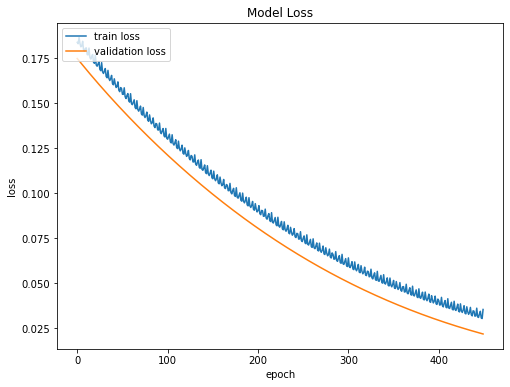

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc = 'upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [62]:
# serialize model to JSON
model_json = convLSTM.to_json()
with open("model_1.json", "w") as json_file:
    json_file.write(model_json)

In [63]:
convLSTM.save_weights("convLSTM_Non_Volatile_1.h5")
print("Saved model to disk")

Saved model to disk


In [64]:
data_val = x_scaler.fit_transform(model1[['is_incart', 'is_special_buy', 'is_bau', 'is_major_event', 'is_event',
       'ty_regular_retail', 'ty_effective_retail', 'markdown',
       'ty_promo_gross_demand', 'promo_pen','lagprice1',
       'lagprice2', 'lagprice3', 'lagprice4', 'lagprice5', 'lagprice7',
       'lagprice11', 'weekend_indi', 'isLeapYear', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'dayofweek_7', 'dayofweek_8', 'dayofweek_9',
       'dayofweek_10', 'dayofweek_11', 'dayofweek_12', 'dayofweek_13',
       'dayofweek_14', 'dayofweek_15', 'dayofweek_16', 'dayofweek_17',
       'dayofweek_18', 'dayofweek_19', 'dayofweek_20', 'dayofweek_21',
       'dayofweek_22', 'dayofweek_23', 'dayofweek_24', 'dayofweek_25',
       'dayofweek_26', 'dayofweek_27', 'dayofweek_28', 'dayofweek_29',
       'dayofweek_30', 'dayofweek_31', 'Weekday_0', 'Weekday_1', 'Weekday_2',
       'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'quarter_1',
       'quarter_2', 'quarter_3', 'quarter_4', 'merch_dept_25H-HARDWARE (25H)',
       'class_nbr_025-012', 'class_name_PNEUMATIC FASTENERS',
       'mfg_brand_name_RYOBI',
       'internet_sku_name_203810823-ONE  18V Cordless AirStrike 18 Gauge Brad Nailer  Tool Only  with Sample Nails',
       'oms_id_203810823', 'Is_Holiday', 'ty_gross_demand']].tail(hist_window))

val_rescaled = data_val.reshape(1,data_val.shape[0], data_val.shape[1])

Predicted_results = convLSTM.predict(val_rescaled)
Predicted_results

Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
Predicted_results_Inv_trans

array([[7097.178 , 6843.909 , 6819.557 , 6487.989 , 6624.0425, 7021.4854,
        6738.4653, 7054.705 , 7272.2417, 7269.09  , 6808.8325, 6942.78  ,
        6843.9414, 7046.7095, 6830.069 ]], dtype=float32)

In [65]:
Predicted_results_Inv_trans[0]

array([7097.178 , 6843.909 , 6819.557 , 6487.989 , 6624.0425, 7021.4854,
       6738.4653, 7054.705 , 7272.2417, 7269.09  , 6808.8325, 6942.78  ,
       6843.9414, 7046.7095, 6830.069 ], dtype=float32)

In [66]:
validate['ty_gross_demand']

cal_dt
2021-10-04    7155.0
2021-10-05    6530.0
2021-10-06    6637.0
2021-10-07    6193.0
2021-10-08    6738.0
2021-10-09    5453.0
2021-10-10    5838.0
2021-10-11    6933.0
2021-10-12    6034.0
2021-10-13    6797.0
2021-10-14    9140.0
2021-10-15    8647.0
2021-10-16    7041.0
2021-10-17    5691.0
2021-10-18    6266.0
Name: ty_gross_demand, dtype: float64

In [67]:
timeseries_evaluation_metrics_func(validate['ty_gross_demand'], Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is: 1054052.2654997825
MAE is: 761.0964192708333
RMSE is: 1026.6704756151228
MAPE is: 11.271142844888002
R2 is : -0.10199816833172681



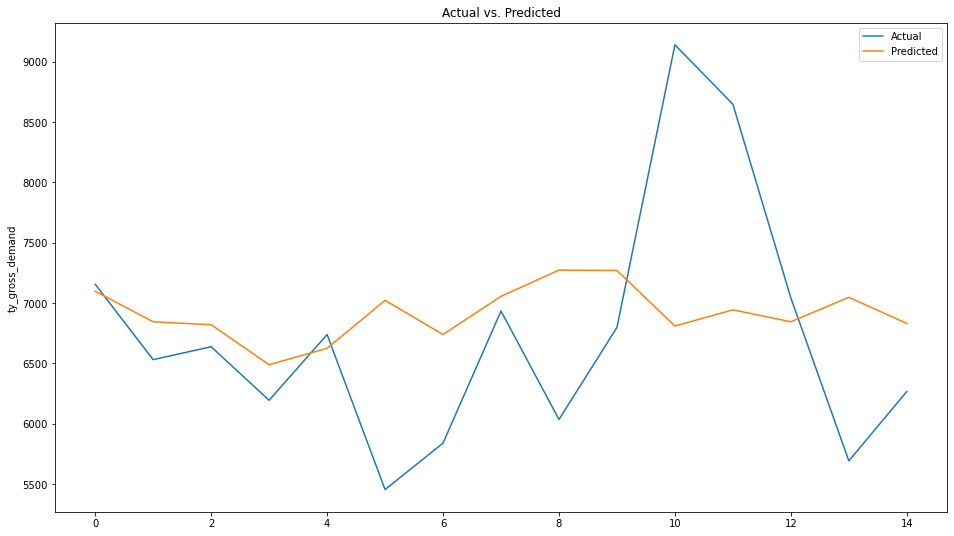

In [68]:
plt.plot(list(validate['ty_gross_demand']))
plt.plot(list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs. Predicted")
plt.ylabel("ty_gross_demand")
plt.legend(('Actual','Predicted'))
plt.show()

In [69]:
pred1 = df1.copy()

In [70]:
yhat = convLSTM.predict(np.array(pred1.tail(hist_window)).reshape(1, hist_window, pred1.shape[1])).tolist()[0]

In [71]:
yhat = y_scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

In [72]:
preds = pd.DataFrame(yhat, index = pd.date_range(start = pred1.index[-1], periods = len(yhat), freq = 'D'))

In [73]:
print(preds)

                      0
2021-10-18  6940.938889
2021-10-19  6679.034575
2021-10-20  6675.721721
2021-10-21  6883.911425
2021-10-22  6734.822089
2021-10-23  6414.889599
2021-10-24  7590.778898
2021-10-25  7264.017933
2021-10-26  6596.385378
2021-10-27  7022.663228
2021-10-28  7149.563304
2021-10-29  6755.181330
2021-10-30  7238.566147
2021-10-31  7274.800388
2021-11-01  6479.727650


In [74]:
periods = 15

In [75]:
actual = pd.DataFrame(pred1['ty_gross_demand'].tail(periods), index = pred1.ty_gross_demand.tail(periods).index).append(preds.head(1))

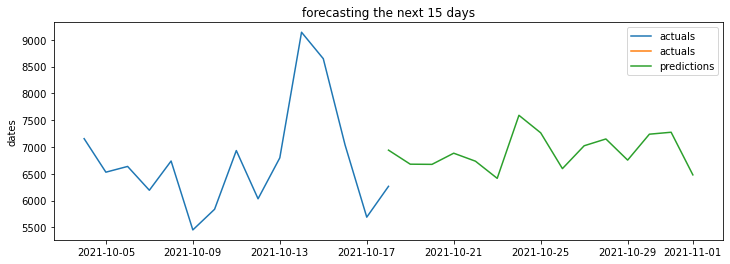

In [76]:
plt.figure(figsize=(12,4))
plt.plot(actual, label='actuals')
plt.plot(preds, label='predictions')
plt.ylabel("price")
plt.ylabel('dates')
plt.title(f'forecasting the next {len(yhat)} days')
plt.legend()
plt.show()

### Load the Model

In [77]:
from keras.models import model_from_json

# load json and create model
json_file = open('model_805.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("convLSTM_Non_Volatile_805.h5")
print("Loaded model from disk")

Loaded model from disk


In [78]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 25)             6100      
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 25)             100       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 25)             0         
_________________________________________________________________
p_re_lu (PReLU)              (None, 5, 25)             125       
_________________________________________________________________
dropout (Dropout)            (None, 5, 25)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 25)             1900      
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 25)             1

In [79]:
data_val = x_scaler.fit_transform(model1[['is_incart', 'is_special_buy', 'is_bau', 'is_major_event', 'is_event',
       'ty_regular_retail', 'ty_effective_retail', 'markdown',
       'ty_promo_gross_demand', 'promo_pen','lagprice1',
       'lagprice2', 'lagprice3', 'lagprice4', 'lagprice5', 'lagprice7',
       'lagprice11', 'weekend_indi', 'isLeapYear', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'dayofweek_7', 'dayofweek_8', 'dayofweek_9',
       'dayofweek_10', 'dayofweek_11', 'dayofweek_12', 'dayofweek_13',
       'dayofweek_14', 'dayofweek_15', 'dayofweek_16', 'dayofweek_17',
       'dayofweek_18', 'dayofweek_19', 'dayofweek_20', 'dayofweek_21',
       'dayofweek_22', 'dayofweek_23', 'dayofweek_24', 'dayofweek_25',
       'dayofweek_26', 'dayofweek_27', 'dayofweek_28', 'dayofweek_29',
       'dayofweek_30', 'dayofweek_31', 'Weekday_0', 'Weekday_1', 'Weekday_2',
       'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'quarter_1',
       'quarter_2', 'quarter_3', 'quarter_4', 'merch_dept_25H-HARDWARE (25H)',
       'class_nbr_025-012', 'class_name_PNEUMATIC FASTENERS',
       'mfg_brand_name_RYOBI',
       'internet_sku_name_203810823-ONE  18V Cordless AirStrike 18 Gauge Brad Nailer  Tool Only  with Sample Nails',
       'oms_id_203810823', 'Is_Holiday', 'ty_gross_demand']].tail(hist_window))

val_rescaled = data_val.reshape(1,data_val.shape[0], data_val.shape[1])

Predicted_results = loaded_model.predict(val_rescaled)
Predicted_results

Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
Predicted_results_Inv_trans

array([[6804.602 , 7345.6846, 6901.8403, 6413.0435, 6699.5146, 7096.283 ,
        6741.5825, 6408.393 , 6910.11  , 6579.9917, 7506.3228, 7668.4644,
        7588.8374, 6145.0903, 6891.243 ]], dtype=float32)

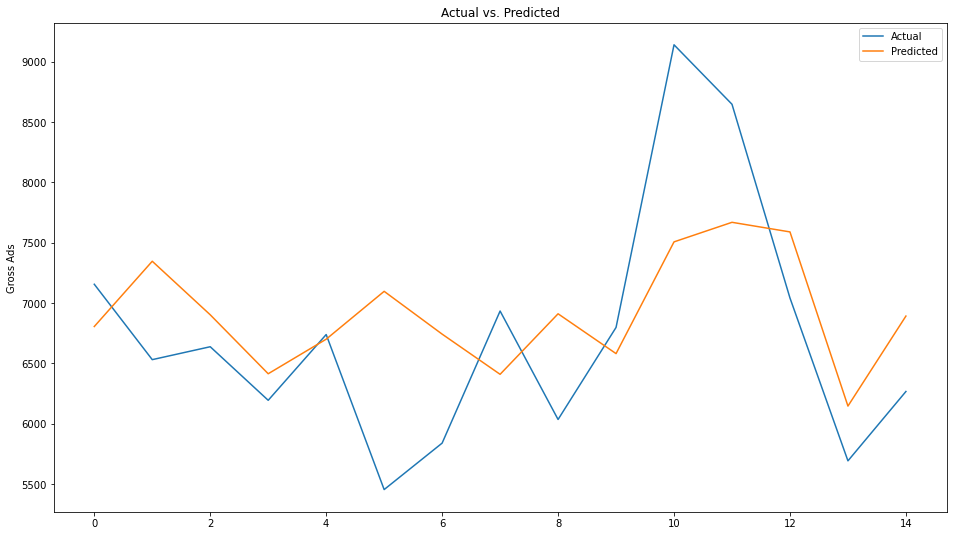

In [80]:
plt.plot(list(validate['ty_gross_demand']))
plt.plot(list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs. Predicted")
plt.ylabel("Gross Ads")
plt.legend(('Actual','Predicted'))
plt.show()

In [81]:
timeseries_evaluation_metrics_func(validate['ty_gross_demand'], Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is: 669237.4325518131
MAE is: 672.8950846354167
RMSE is: 818.0693323623696
MAPE is: 10.088254197466364
R2 is : 0.3003208199534221



### Hyperparameter Tuning

In [82]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPool1D,
    TimeDistributed,
    BatchNormalization,
    LSTM,
    GRU,
    SimpleRNN,
    PReLU,
    LeakyReLU,
    MaxPooling1D
    
)

INPUT_SHAPE = (x_train_multi.shape[1], x_train_multi.shape[2])
NUM_CLASSES = 1
input_shape = (x_train_multi.shape[1], x_train_multi.shape[2])
num_classes = 1

In [83]:
from kerastuner import HyperModel


class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(
            Conv1D(
                filters=hp.Choice(
                    'Conv1D_Filters_1',
                    values=[5, 10, 15, 20, 25, 50, 100, 150, 200, 300, 400, 500],
                    default=25,
                ),
                kernel_size=3,
                strides=1,
                padding = "causal",
                activation= hp.Choice(
                    'Conv1D_Activation_1',
                    values=['relu', 'tanh', 'sigmoid', 'swish','elu','selu'],
                    default='relu'
                ),
                input_shape=self.input_shape
            ))
        
        model.add(BatchNormalization())
        
        model.add(
                LeakyReLU(alpha=hp.Float(
                'LeakyReLU_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )))
        
        model.add(PReLU())
        
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_1',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05)
            ))
        
        model.add(
            Conv1D(
                filters=hp.Choice(
                    'Conv1D_Filters_2',
                    values=[5, 10, 15, 20, 25, 50, 100, 150, 200, 300, 400, 500],
                    default=25,
                ),
                kernel_size=3,
                strides=1,
                padding = "causal",
                activation= hp.Choice(
                    'Conv1D_Activation_2',
                    values=['relu', 'tanh', 'sigmoid', 'swish','elu','selu'],
                    default='relu'
                )
            ))
        
        model.add(BatchNormalization())
        
        model.add(
                LeakyReLU(alpha=hp.Float(
                'LeakyReLU_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )))
        
        model.add(PReLU())
        
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_2',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05)
            ))
        
        
        model.add(MaxPooling1D(pool_size=1, strides=1, padding='same'))
        
        model.add(
            Conv1D(
                filters=hp.Choice(
                    'Conv1D_Filters_3',
                    values=[5, 10, 15, 20, 25, 50, 100, 150, 200, 300, 400, 500],
                    default=25,
                ),
                kernel_size=3,
                strides=1,
                padding = "causal",
                activation= hp.Choice(
                    'Conv1D_Activation_3',
                    values=['relu', 'tanh', 'sigmoid', 'swish','elu','selu'],
                    default='relu'
                )
            ))
        
        model.add(BatchNormalization())
        
        model.add(
                LeakyReLU(alpha=hp.Float(
                'LeakyReLU_3',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )))
        
        model.add(PReLU())
        
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_3',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05)
            ))      
        
        model.add(MaxPooling1D(pool_size=1, strides=1, padding='same'))
        
        
        model.add(
            Conv1D(
                filters=hp.Choice(
                    'Conv1D_Filters_4',
                    values=[5, 10, 15, 20, 25, 50, 100, 150, 200, 300, 400, 500],
                    default=25,
                ),
                kernel_size=3,
                strides=1,
                padding = "causal",
                activation= hp.Choice(
                    'Conv1D_Activation_4',
                    values=['relu', 'tanh', 'sigmoid', 'swish','elu','selu'],
                    default='relu'
                )
            ))
        
        model.add(BatchNormalization())
        
        model.add(
                LeakyReLU(alpha=hp.Float(
                'LeakyReLU_4',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )))
        
        model.add(PReLU())
        
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_4',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05)
            ))            
        
        
        model.add(MaxPooling1D(pool_size=1, strides=1, padding='same'))

        model.add(
            TimeDistributed(Dense(
                units=hp.Choice(
                    'TimeDistributed_units_1',
                    values=[1, 5, 10, 30, 40, 80, 100, 200, 300, 500],
                    default=30,
                ), activation = hp.Choice(
                    'TimeDistributed_Activation_1',
                    values=['relu', 'tanh', 'sigmoid', 'swish', 'selu', 'elu'],
                    default='tanh'
                ))))

        model.add(
            Bidirectional(LSTM(
                units=hp.Choice(
                    'Bidirectional_units',
                    values=[1, 5, 10, 30, 40, 80, 100, 200, 300, 500],
                    default=30,
                ), activation = hp.Choice(
                    'Bidirectional_Activation',
                    values=['relu', 'tanh', 'sigmoid', 'selu', 'elu'],
                    default='tanh'
                ), go_backwards=True, return_sequences = True)))
        
        model.add(Flatten())
        
        model.add(
            Dense(
                units= 1,
                kernel_regularizer=regularizers.l2(0.01),
                bias_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid','linear','swish','softmax'],
                    default='softmax'
                )
            )
        )
        
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=.00001,
                    max_value=.01,
                    sampling='LOG',
                    default=.00001
                )
            ),
            loss=tf.losses.MeanSquaredError(),
            metrics=['accuracy']
        )
        
        return model

hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

In [84]:
HYPERBAND_MAX_EPOCHS = 60
MAX_TRIALS = 60
EXECUTION_PER_TRIAL = 60

In [85]:
from kerastuner.tuners import Hyperband


tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_accuracy',
    seed=1,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='/home/jupyter',
    project_name='hyperband4'
)

INFO:tensorflow:Reloading Oracle from existing project /home/jupyter/hyperband4/oracle.json
INFO:tensorflow:Reloading Tuner from /home/jupyter/hyperband4/tuner0.json


In [86]:
tuner.search_space_summary()

In [87]:
N_EPOCH_SEARCH = 60

In [88]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [89]:
'''
import time
start = time.time()
EVALUATION_INTERVAL = 50
EPOCHS = 60
tuner.search(train_data_multi, epochs = EPOCHS, validation_steps=50, validation_data = val_data_multi, steps_per_epoch=EVALUATION_INTERVAL, callbacks = [ClearTrainingOutput()])
'''

'\nimport time\nstart = time.time()\nEVALUATION_INTERVAL = 50\nEPOCHS = 60\ntuner.search(train_data_multi, epochs = EPOCHS, validation_steps=50, validation_data = val_data_multi, steps_per_epoch=EVALUATION_INTERVAL, callbacks = [ClearTrainingOutput()])\n'

In [90]:
tuner.results_summary()

In [91]:
best_model = tuner.get_best_models(num_models=1)[0]

In [92]:
best_model = tuner.get_best_models(num_models=1)[0]

In [93]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [94]:
print(best_hps.get('Conv1D_Filters_1'))
print(best_hps.get('Conv1D_Activation_1'))
print(best_hps.get('LeakyReLU_1'))
print(best_hps.get('dropout_1'))
print(best_hps.get('Conv1D_Filters_2'))
print(best_hps.get('Conv1D_Activation_2'))
print(best_hps.get('LeakyReLU_2'))
print(best_hps.get('dropout_2'))
print(best_hps.get('Conv1D_Filters_3'))
print(best_hps.get('Conv1D_Activation_3'))
print(best_hps.get('LeakyReLU_3'))
print(best_hps.get('dropout_3'))
print(best_hps.get('Conv1D_Filters_4'))
print(best_hps.get('Conv1D_Activation_4'))
print(best_hps.get('LeakyReLU_4'))
print(best_hps.get('dropout_4'))
print(best_hps.get('TimeDistributed_units_1'))
print(best_hps.get('TimeDistributed_Activation_1'))
print(best_hps.get('Bidirectional_units'))
print(best_hps.get('Bidirectional_Activation'))
print(best_hps.get('dense_activation'))
print(best_hps.get('learning_rate'))

25
selu
0.2
0.35000000000000003
400
relu
0.25
0.25
5
relu
0.30000000000000004
0.25
200
sigmoid
0.35000000000000003
0.30000000000000004
30
swish
100
relu
relu
0.0001681154540009978


In [95]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

leaky_relu_alpha = 0.1
filter_num = 25
activation_conv = 'tanh'
LSTM_act = 'tanh'
dense_act = 'softmax'
conv_dropout = .15
convLSTM_tuned = tf.keras.models.Sequential([ 
                                        # Conv1
                                        tf.keras.layers.Conv1D(activation = 'relu', filters=15, strides=1, padding = "causal", kernel_size = 3, input_shape = (x_train_multi.shape[1], x_train_multi.shape[2])),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.LeakyReLU(alpha=0.1),
                                        tf.keras.layers.PReLU(),
                                        tf.keras.layers.Dropout(0.1),
    
                                        # Conv2
                                        tf.keras.layers.Conv1D(activation = 'elu',filters=300, strides=1, kernel_size = 3, padding = "causal"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.LeakyReLU(alpha=0.15000000000000002),
                                        tf.keras.layers.PReLU(),
                                        tf.keras.layers.Dropout(0.1),
    
                                        # Pool 1
                                        tf.keras.layers.MaxPooling1D(pool_size=1, strides=1, padding='same'),
    
                                        # Conv3
                                        tf.keras.layers.Conv1D(activation = 'elu',filters=150, strides=1, kernel_size = 3,padding = "causal"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.LeakyReLU(alpha=0.25),
                                        tf.keras.layers.PReLU(),
                                        tf.keras.layers.Dropout(0.25),
                                        
                                        # Pool 2
                                        tf.keras.layers.MaxPooling1D(pool_size=1, strides=1, padding='same'),
    
                                        # Conv4
                                        tf.keras.layers.Conv1D(activation = 'relu',filters=25, strides=1, kernel_size = 3, padding = "causal"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.LeakyReLU(alpha=0.5),
                                        tf.keras.layers.PReLU(),
                                        tf.keras.layers.Dropout(0.2),
    
                                        # Pool 3
                                        tf.keras.layers.MaxPooling1D(pool_size=1, strides=1, padding='same'),
    
                                        # Time Distributed Layer
                                        tf.keras.layers.TimeDistributed(Dense(10, activation = 'tanh')),
                                        
                                        # Hidden Layer 500
                                        tf.keras.layers.Bidirectional(LSTM(10,activation = 'tanh', return_sequences = True, go_backwards=True)),
    
                                        # Hidden Layer 250
                                        #tf.keras.layers.Bidirectional(LSTM(250,activation = 'tanh', return_sequences = True, go_backwards=False)),
                                        
                                        # Hidden Layer 125
                                        #tf.keras.layers.Bidirectional(LSTM(125,activation = 'tanh', return_sequences = True, go_backwards=True)),
    
                                        # Output Layer
                                        #tf.keras.layers.MaxPool1D(pool_size = 1),
                                        #tf.keras.layers.PReLU(),
                                        #tf.keras.layers.Dropout(0.15),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(horizon, activation = 'tanh',
                                        kernel_regularizer=regularizers.l2(0.01),
                                        bias_regularizer=regularizers.l2(0.01),
                                        activity_regularizer=regularizers.l2(0.01)),
])

In [96]:
optimizer=tf.optimizers.Adam(learning_rate=0.00749252394311766) #0.00001
convLSTM_tuned.compile(optimizer=optimizer, loss='mse')

In [97]:
import time
start = time.time()
EVALUATION_INTERVAL = 50
EPOCHS = 100 # 500
history = convLSTM_tuned.fit(train_data_multi, epochs = EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose = 1,
                         callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode = 'min')
                                      ])

print('Duration: {} seconds'.format(time.time() - start))

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.285 - ETA: 0s - loss: 0.209 - ETA: 0s - loss: 0.151 - ETA: 0s - loss: 0.112 - ETA: 0s - loss: 0.091 - ETA: 0s - loss: 0.078 - ETA: 0s - loss: 0.072 - ETA: 0s - loss: 0.062 - 1s 26ms/step - loss: 0.0590 - val_loss: 0.0133
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.011 - 1s 11ms/step - loss: 0.0117 - val_loss: 0.0053
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.019 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.017 - 1s 11ms/step - loss: 0.0177 - val_loss: 0.0063
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.019 - ETA: 0s - loss: 0.015 -

In [98]:
convLSTM_tuned.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 5, 15)             3660      
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 15)             60        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 5, 15)             0         
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 5, 15)             75        
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 15)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 300)            13800     
_________________________________________________________________
batch_normalization_5 (Batch (None, 5, 300)           

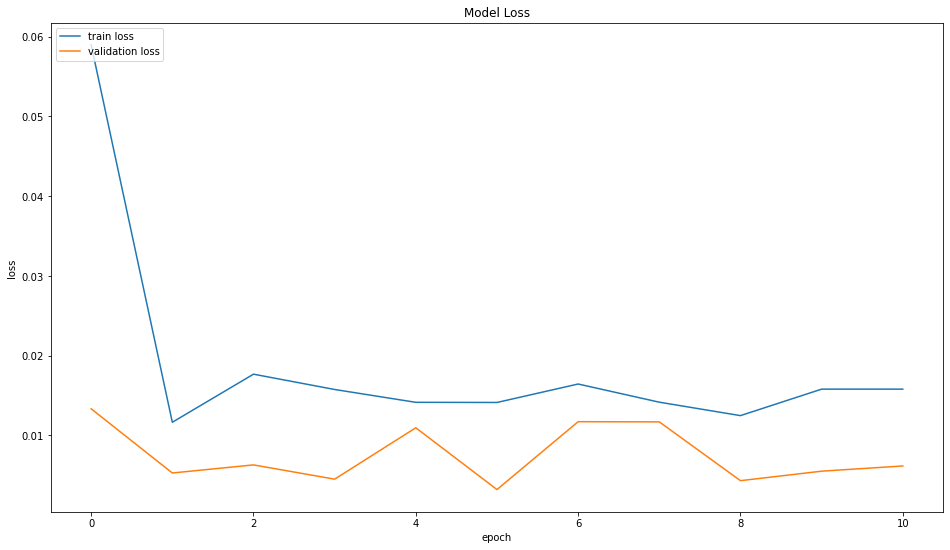

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc = 'upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [100]:
# serialize model to JSON
model_json = convLSTM_tuned.to_json()
with open("model_tuned.json", "w") as json_file:
    json_file.write(model_json)

In [101]:
convLSTM_tuned.save_weights("convLSTM_Non_Volatile_tuned.h5")
print("Saved model to disk")

Saved model to disk


In [102]:
data_val = x_scaler.fit_transform(model1[['is_incart', 'is_special_buy', 'is_bau', 'is_major_event', 'is_event',
       'ty_regular_retail', 'ty_effective_retail', 'markdown',
       'ty_promo_gross_demand', 'promo_pen','lagprice1',
       'lagprice2', 'lagprice3', 'lagprice4', 'lagprice5', 'lagprice7',
       'lagprice11', 'weekend_indi', 'isLeapYear', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'dayofweek_7', 'dayofweek_8', 'dayofweek_9',
       'dayofweek_10', 'dayofweek_11', 'dayofweek_12', 'dayofweek_13',
       'dayofweek_14', 'dayofweek_15', 'dayofweek_16', 'dayofweek_17',
       'dayofweek_18', 'dayofweek_19', 'dayofweek_20', 'dayofweek_21',
       'dayofweek_22', 'dayofweek_23', 'dayofweek_24', 'dayofweek_25',
       'dayofweek_26', 'dayofweek_27', 'dayofweek_28', 'dayofweek_29',
       'dayofweek_30', 'dayofweek_31', 'Weekday_0', 'Weekday_1', 'Weekday_2',
       'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'quarter_1',
       'quarter_2', 'quarter_3', 'quarter_4', 'merch_dept_25H-HARDWARE (25H)',
       'class_nbr_025-012', 'class_name_PNEUMATIC FASTENERS',
       'mfg_brand_name_RYOBI',
       'internet_sku_name_203810823-ONE  18V Cordless AirStrike 18 Gauge Brad Nailer  Tool Only  with Sample Nails',
       'oms_id_203810823', 'Is_Holiday', 'ty_gross_demand']].tail(hist_window))

val_rescaled = data_val.reshape(1,data_val.shape[0], data_val.shape[1])

Predicted_results = convLSTM_tuned.predict(val_rescaled)
Predicted_results

Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
Predicted_results_Inv_trans

array([[3966.2861, 3465.723 , 3481.4954, 2872.134 , 3453.2844, 3608.676 ,
        3283.8433, 4048.0393, 2794.643 , 2758.8406, 3156.8193, 2927.0676,
        2620.5916, 3364.1047, 2967.4846]], dtype=float32)

In [103]:
Predicted_results_Inv_trans[0]

array([3966.2861, 3465.723 , 3481.4954, 2872.134 , 3453.2844, 3608.676 ,
       3283.8433, 4048.0393, 2794.643 , 2758.8406, 3156.8193, 2927.0676,
       2620.5916, 3364.1047, 2967.4846], dtype=float32)

In [104]:
timeseries_evaluation_metrics_func(validate['ty_gross_demand'], Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is: 13382103.397515437
MAE is: 3488.264469401042
RMSE is: 3658.155737187174
MAPE is: 50.773987488340886
R2 is : -12.990818022193068



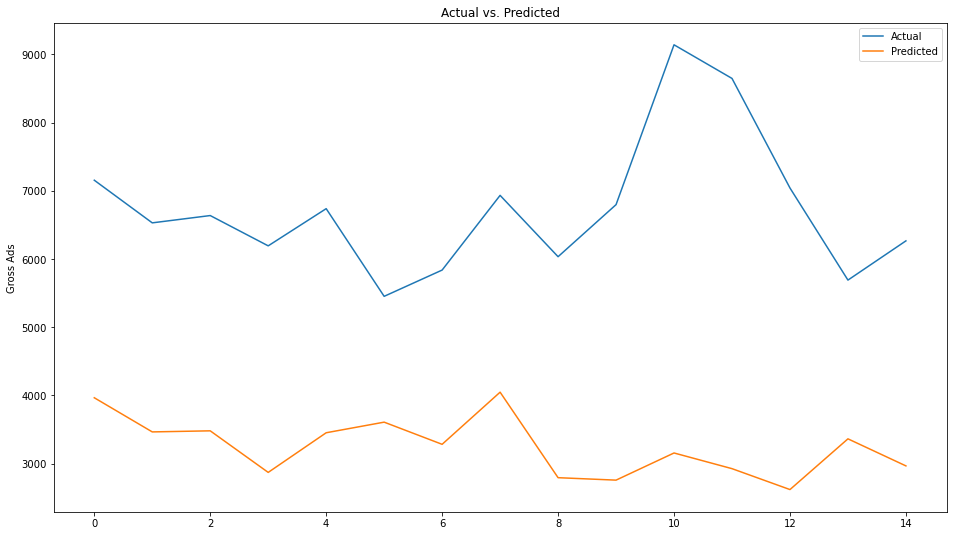

In [105]:
plt.plot(list(validate['ty_gross_demand']))
plt.plot(list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs. Predicted")
plt.ylabel("Gross Ads")
plt.legend(('Actual','Predicted'))
plt.show()